# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using various deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

Data can be downloaded from https://www.kaggle.com/c/facial-keypoints-detection/data

In the following lines we provide a simple solution: a neural net with a single hidden layer. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by extending the baseline model to convolutional neural nets.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout or BatchNorm.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
    
For developing puposes it is not a bad idea to work with 43x43 images...
    
Advanced suggestions:
+ Use several loss functions (f.e. one computing the MSE of predicted points and another measuring a global deformation of the constellation of points).
+ Can we work in a lower dimensional space for representing points? This could help with hidden points, global deformations, etc.
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

!pip install nolearn

In [16]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from nolearn.lasagne import BatchIterator
import tensorflow as tf

In [17]:
# utilities

FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '/training.csv'
FTEST = FROOT + '/test.csv'
FLOOKUP = FROOT + '/IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    img = x.reshape(96, 96)
    pyplot.imshow(img, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

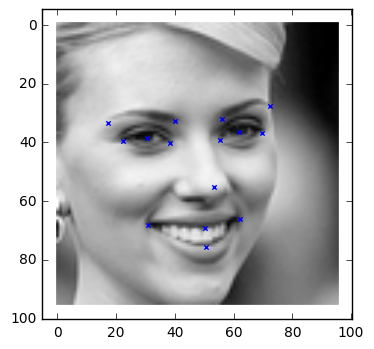

In [18]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [19]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

In [22]:
# Predefined parameters

image_size = 96
num_keypoints = 30
batch_size = 36
num_epochs = 1001
learning_rate = 0.01
momentum = 0.9

model_name = "1fc_b" + str(batch_size) + "_e" + str(num_epochs - 1)
model_variable_scope = model_name
root_location = FROOT + "/models/"
model_path = root_location + model_name + "/model.ckpt"
train_history_path = root_location + model_name + "/train_history"

os.makedirs(root_location + model_name + "/")

In [23]:
# model definition

def fully_connected(input, size):
    """
    Creates a fully connected TensorFlow layer.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def model_pass(input):
    """
    Performs a whole model pass.
    """
    with tf.variable_scope('hidden'):
        hidden = fully_connected(input, size = 100)
    relu_hidden = tf.nn.relu(hidden)
    with tf.variable_scope('out'):
        prediction = fully_connected(relu_hidden, size = num_keypoints)
    return prediction

def calc_loss(predictions, labels):
    """
    Calculates loss with NumPy.
    """
    return np.mean(np.square(predictions - labels))

def get_time_hhmmss(start):
    """
    Calculates time since `start` and formats as a string.
    """
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

In [24]:
# training

graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size * image_size))
    tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))

    # Training computation.
    with tf.variable_scope(model_variable_scope):
        predictions = model_pass(tf_x_batch)
    
    loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

    # Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate, 
        momentum = momentum, 
        use_nesterov = True
    ).minimize(loss)
    
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.   
    Returns N-dimensional array of predictions.
    """
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, _ in batch_iterator(X):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch 
            }
        )
        p.extend(p_batch)
    return p

start = time.time()
every_epoch_to_log = 5

with tf.Session(graph = graph) as session:
    session.run(tf.initialize_all_variables())
    saver = tf.train.Saver()
    train_loss_history = np.zeros(num_epochs)
    valid_loss_history = np.zeros(num_epochs)
    print("============ TRAINING =============")
    for epoch in range(num_epochs):
        # Train on whole randomised dataset in batches
        batch_iterator = BatchIterator(batch_size = batch_size, shuffle = True)
        for x_batch, y_batch in batch_iterator(x_train, y_train):
            session.run([optimizer], feed_dict = {
                    tf_x_batch : x_batch, 
                    tf_y_batch : y_batch
                }
            )

        # If another significant epoch ended, we log our losses.
        if (epoch % every_epoch_to_log == 0):
            # Get training data predictions and log training loss:
            train_loss = calc_loss(
                get_predictions_in_batches(x_train, session), 
                y_train
            )
            train_loss_history[epoch] = train_loss

            # Get validation data predictions and log validation loss:
            valid_loss = calc_loss(
                get_predictions_in_batches(x_valid, session), 
                y_valid
            )
            valid_loss_history[epoch] = valid_loss
            
            if (epoch % 100 == 0):
                print("--------- EPOCH %4d/%d ---------" % (epoch, num_epochs))
                print("     Train loss: %.8f" % (train_loss))
                print("Validation loss: %.8f" % (valid_loss))
                print("           Time: " + get_time_hhmmss(start))

    # Evaluate on test dataset.
    test_loss = calc_loss(
        get_predictions_in_batches(x_test, session), 
        y_test
    )
    print("===================================")
    print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
    print(" Total time: " + get_time_hhmmss(start))
    
    # Save model weights for future use.
    save_path = saver.save(session, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, 
             train_loss_history = train_loss_history, 
             valid_loss_history = valid_loss_history)
    print("Train history file: " + train_history_path)

============ TRAINING =============
--------- EPOCH    0/1001 ---------
     Train loss: 0.01361557
Validation loss: 0.01292812
           Time: 00:00:00
--------- EPOCH  100/1001 ---------
     Train loss: 0.00275340
Validation loss: 0.00366329
           Time: 00:01:46
--------- EPOCH  200/1001 ---------
     Train loss: 0.00195783
Validation loss: 0.00306949
           Time: 00:03:41
--------- EPOCH  300/1001 ---------
     Train loss: 0.00163280
Validation loss: 0.00279423
           Time: 00:05:33
--------- EPOCH  400/1001 ---------
     Train loss: 0.00145408
Validation loss: 0.00278631
           Time: 00:07:34
--------- EPOCH  500/1001 ---------
     Train loss: 0.00132598
Validation loss: 0.00277621
           Time: 00:09:24
--------- EPOCH  600/1001 ---------
     Train loss: 0.00114980
Validation loss: 0.00268346
           Time: 00:11:22
--------- EPOCH  700/1001 ---------
     Train loss: 0.00105423
Validation loss: 0.00265257
           Time: 00:13:13
--------- EPOCH  800

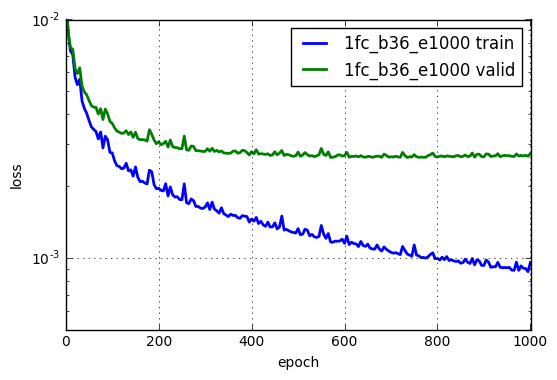

In [25]:
# evaluation

def plot_learning_curves(model = model_name, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    """
    Plots history of learning curves for a specific model based on the saved training history. 
    """
    model_history = np.load(root_location + model + "/train_history.npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], train_linestyle, linewidth=linewidth, label=model + " train")
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], valid_linestyle, linewidth=linewidth, label=model + " valid")
    return epochs

new_model_epochs = plot_learning_curves()

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.0005, 0.01)
pyplot.xlim(0, new_model_epochs)
pyplot.yscale("log")
pyplot.show()

In [26]:
# Load training data, restore saved model parameters and get predictions:

X, _ = load(test = True)

with graph.as_default():
    tf_x = tf.constant(X)

    with tf.variable_scope(model_variable_scope, reuse = True):
        tf_p = model_pass(tf_x)  
        
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    load_path = saver.restore(session, model_path)
    p = tf_p.eval()

ImageId    1783
Image      1783
dtype: int64


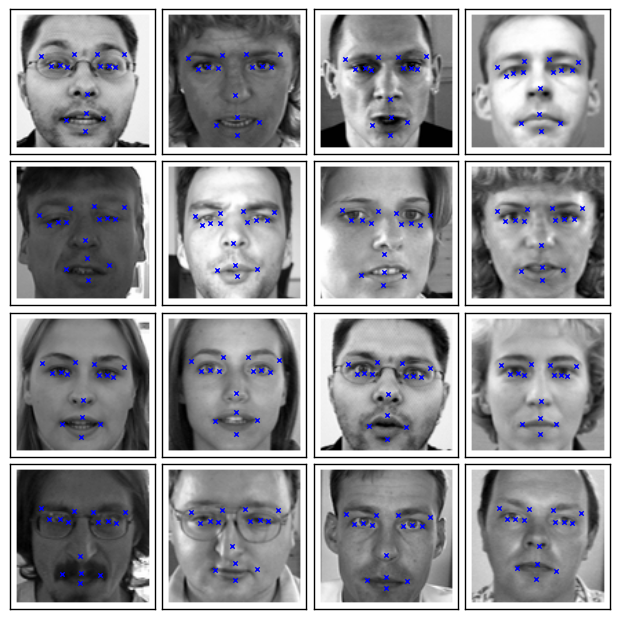

In [28]:
# Display some of the dataset images and our model's predictions:


fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], p[i])

pyplot.show()